# Bayesian Bank Regression
- https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Bayesian%20Logistic%20Regression_bank%20marketing.ipynb
- https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16

***
## Imports

In [5]:
# pip install pymc3

In [6]:
# Data manipulation
import pandas as pd
import numpy as np

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Stats
import pymc3 as pm
# import pymc as pm
import arviz as az
import theano
import theano.tensor as tt
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

# Basics & Options
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns',30)

In [7]:
# import data
df = pd.read_csv('C:\\Users\\wallj\\DS_Projects\\Datasets\\bank-additional-full.csv',sep=';')
print(df.shape)
print(df['y'].value_counts())
df.head()

(41188, 21)
no     36548
yes     4640
Name: y, dtype: int64


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


***
## EDA

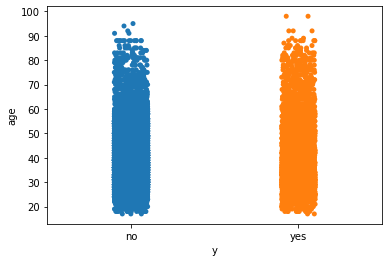

In [8]:
sns.stripplot(x="y",y='age',data=df,jitter=True);

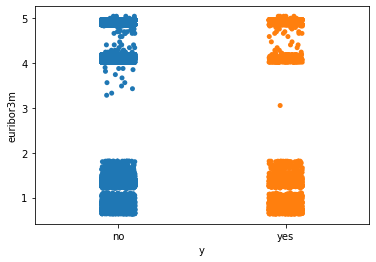

In [9]:
sns.stripplot(x='y',y='euribor3m',data=df,jitter=True);

In [10]:
df['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [11]:
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [12]:
df['poutcome'].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [13]:
# Alternative to case statements!
def replace_education(education):
    """
    This function codes the highest education attained.
    """
    if education == 'university.degree':
        return 8
    elif education == 'professional.course':
        return 7
    elif education == 'high.school':
        return 6
    elif education == 'basic.9y':
        return 5
    elif education == 'basic.6y':
        return 4
    elif education =='basic.4y':
        return 3
    elif education == 'unknown':
        return 2
    elif education == 'illiterate':
        return 1
    
def replace_job(job):
    """
    This function codes the highest job earned.
    """
    if job == 'management':
        return 12
    elif job == 'admin.':
        return 11
    elif job == 'entrepreneur':
        return 10
    elif job == 'technician':
        return 9
    elif job == 'services':
        return 8
    elif job == 'self-employed':
        return 7
    elif job == 'blue-collar':
        return 6
    elif job == 'retired':
        return 5
    elif job == 'housemaid':
        return 4
    elif job == 'unemployed':
        return 3
    elif job == 'unknown':
        return 2
    elif job == 'student':
        return 1
    
def replace_marital(marital):
    if marital == 'married':
        return 4
    elif marital == 'single':
        return 3
    elif marital == 'divorced':
        return 2
    elif marital == 'unknown':
        return 1
    
def replace_default(default):
    if default == 'no':
        return 0
    elif default == 'yes':
        return 1
    elif default == 'unknown':
        return 2
    
def replace_housing(housing):
    if housing == 'no':
        return 0
    elif housing == 'yes':
        return 1
    elif housing == 'unknown':
        return 2

def replace_loan(loan):
    if loan == 'no':
        return 0
    elif loan == 'yes':
        return 1
    elif loan == 'unknown':
        return 2
    
def replace_contact(contact):
    if contact == 'cellular':
        return 1
    elif contact == 'telephone':
        return 2
    
def replace_poutcome(poutcome):
    if poutcome == 'failure':
        return 0
    elif poutcome == 'success':
        return 1
    elif poutcome == 'nonexistent':
        return 2
    
def replace_y(y):
    if y == 'yes':
        return 1
    elif y == 'no':
        return 0

In [14]:
# Apply Functions above
df['education'] = df['education'].apply(lambda x: replace_education(x))
df['job'] = df['job'].apply(lambda x: replace_job(x))
df['marital'] = df['marital'].apply(lambda x: replace_marital(x))
df['default'] = df['default'].apply(lambda x: replace_default(x))
df['housing'] = df['housing'].apply(lambda x: replace_housing(x))
df['loan'] = df['loan'].apply(lambda x: replace_loan(x))
df['contact'] = df['contact'].apply(lambda x: replace_contact(x))
df['poutcome'] = df['poutcome'].apply(lambda x: replace_poutcome(x))
df['y'] = df['y'].apply(lambda x: replace_y(x))

In [15]:
df['month'].value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

In [16]:
look_up_month = {'aug': 8, 'nov': 11, 'jun': 6, 'apr': 4, 'jul': 7,
            'may': 5, 'oct': 10, 'mar': 3, 'sep': 9, 'dec': 12}

look_up_dow = {'thu': 4, 'fri': 5, 'tue': 2, 'mon': 1, 'wed': 3}

In [17]:
df['month'] = df['month'].apply(lambda x: look_up_month[x])

df['day_of_week'] = df['day_of_week'].apply(lambda x: look_up_dow[x])

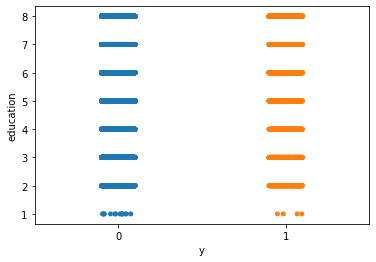

In [18]:
sns.stripplot(x="y", y="education", data=df, jitter=True);

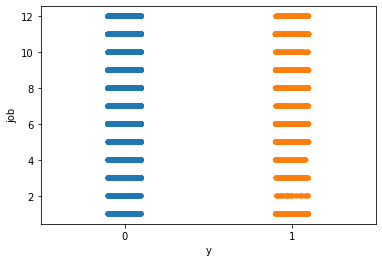

In [19]:
sns.stripplot(x="y", y="job", data=df, jitter=True);

***
## Modeling

In [20]:
outcome = df['y']
data = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'euribor3m']]
data['outcome'] = outcome
data.corr()['outcome'].sort_values(ascending=False)

outcome        1.000000
duration       0.405274
previous       0.230181
month          0.037187
education      0.035848
age            0.030399
day_of_week    0.010051
housing        0.009552
loan          -0.005038
job           -0.023020
marital       -0.026302
campaign      -0.066357
default       -0.099324
poutcome      -0.122089
contact       -0.144773
euribor3m     -0.307771
pdays         -0.324914
Name: outcome, dtype: float64

In [27]:
y_simple = data['outcome']
x_n = 'duration'
x_0 = data[x_n].values
x_c = x_0 - x_0.mean()

In [28]:
# Create the model
with pm.Model() as model_simple:
    a = pm.Normal('a',mu=0,sd=10) # Flat normal - no prior info
    b = pm.Normal('b',mu=0,sd=10) # Flat normal - no prior info
    
    u = a + pm.math.dot(x_c,b)
    O = pm.Deterministic('O',pm.math.sigmoid(u))
    bd = pm.Deterministic('bd',-a/b)
    
    y_1 = pm.Bernoulli('y_1',p=O,observed=y_simple)
    
    trace_simple = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 455 seconds.


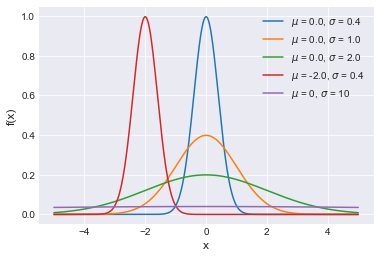

In [24]:
# Testing graphing mu sigma
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(-5, 5, 1000)
mus = [0., 0., 0., -2.,0]
sigmas = [0.4, 1., 2., 0.4,10]
for mu, sigma in zip(mus, sigmas):
    pdf = st.norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()